In [13]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/master_data_fault_analysis/'
X_PATH = DATA_DIR + 'ff8_Fault_Data_X.csv'
Y_PATH = DATA_DIR + 'ff8_Fault_Labels_Y.csv'

print(f'Data will be loaded from: {DATA_DIR}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data will be loaded from: /content/drive/MyDrive/master_data_fault_analysis/


In [14]:
import torch
from torch.utils.data import Dataset
import numpy as np

class FaultDataset(Dataset):
    def __init__(self, x_data, y_data):
        x_raw = x_data.astype(np.float32)
        self.y = torch.tensor(y_data, dtype=torch.long)
        self.x_reshaped = x_raw.reshape(-1, 12, 400)

        for i in range(12):
            mean = self.x_reshaped[:, i, :].mean()
            std = self.x_reshaped[:, i, :].std() + 1e-6

            self.x_reshaped[:, i, :] = (self.x_reshaped[:, i, :] - mean) / std

        self.x = torch.FloatTensor(self.x_reshaped)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [15]:
import pandas as pd
import numpy as np

y_raw = pd.read_csv(Y_PATH, header=None).iloc[:, 0].values
unique_classes, class_counts = np.unique(y_raw, return_counts=True)

print("Class distribution in Y_PATH data:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")
class_names = ['Normal', 'SLG', 'LL', 'DLG', '3P']
print("\nMapping of class IDs to names:")
for i, name in enumerate(class_names):
    print(f"Class {i}: {name}")

Class distribution in Y_PATH data:
Class 0: 2436 samples
Class 1: 2436 samples
Class 2: 2436 samples
Class 3: 2436 samples
Class 4: 2436 samples

Mapping of class IDs to names:
Class 0: Normal
Class 1: SLG
Class 2: LL
Class 3: DLG
Class 4: 3P


In [16]:
import torch.nn as nn

class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(CNNLSTM, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=12, out_channels=128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(100)
        )
        self.lstm = nn.LSTM(input_size=256,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.cnn(x)
        features = features.permute(0, 2, 1)
        lstm_out, _ = self.lstm(features)
        out = torch.mean(lstm_out, dim=1)
        return self.fc(out)

Using device: cuda
Loading data...


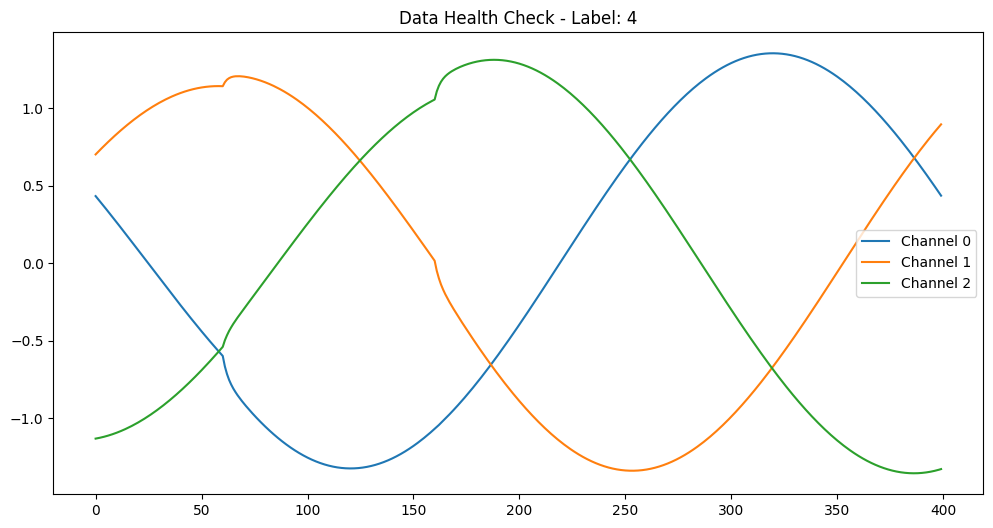

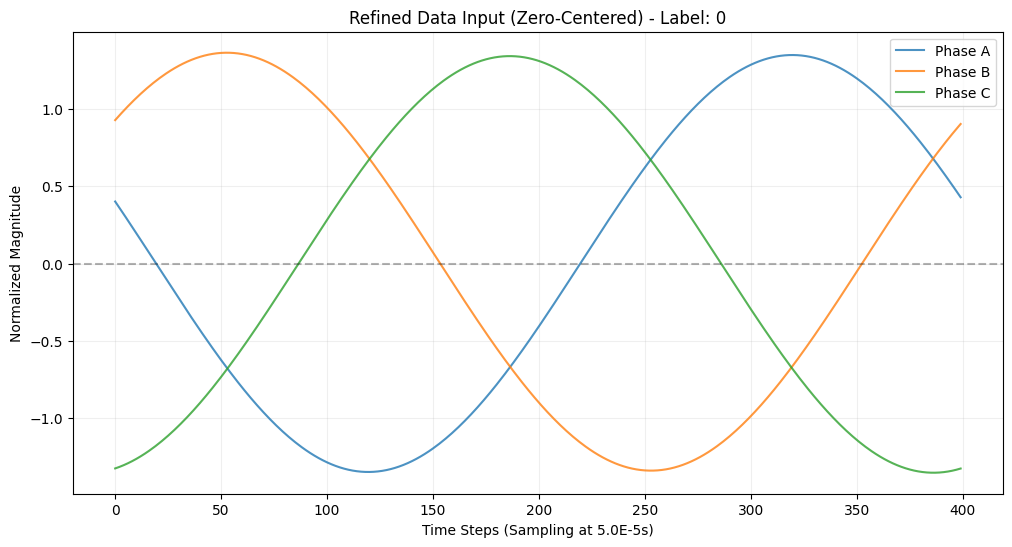

Epoch 1/90: Loss: 1.4770, Train: 31.88%, Val: 39.20%
 -> New Best Accuracy! Model saved to Drive.
Epoch 2/90: Loss: 1.2562, Train: 43.48%, Val: 45.48%
 -> New Best Accuracy! Model saved to Drive.
Epoch 3/90: Loss: 1.1520, Train: 48.50%, Val: 56.36%
 -> New Best Accuracy! Model saved to Drive.
Epoch 4/90: Loss: 1.0473, Train: 53.57%, Val: 59.65%
 -> New Best Accuracy! Model saved to Drive.
Epoch 5/90: Loss: 0.9627, Train: 57.50%, Val: 60.02%
 -> New Best Accuracy! Model saved to Drive.
Epoch 6/90: Loss: 0.9171, Train: 59.12%, Val: 59.24%
Epoch 7/90: Loss: 0.8912, Train: 59.85%, Val: 62.40%
 -> New Best Accuracy! Model saved to Drive.
Epoch 8/90: Loss: 0.8325, Train: 62.17%, Val: 55.87%
Epoch 9/90: Loss: 0.7946, Train: 64.41%, Val: 48.60%
Epoch 10/90: Loss: 0.7477, Train: 66.54%, Val: 66.87%
 -> New Best Accuracy! Model saved to Drive.
Epoch 11/90: Loss: 0.7342, Train: 67.30%, Val: 61.29%
Epoch 12/90: Loss: 0.7788, Train: 65.72%, Val: 67.94%
 -> New Best Accuracy! Model saved to Drive.
E

In [17]:
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_refined_data(dataset, sample_idx=0):
    if len(dataset) <= sample_idx:
        sample_idx = 0
    sample_x, sample_y = dataset[sample_idx]

    plt.figure(figsize=(12, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    labels = ['Phase A', 'Phase B', 'Phase C']

    for i in range(3):
        plt.plot(sample_x[i].numpy(), color=colors[i], label=labels[i], alpha=0.8)

    plt.axhline(0, color='black', linestyle='--', alpha=0.3) # Zero line
    plt.title(f"Refined Data Input (Zero-Centered) - Label: {sample_y}")
    plt.xlabel("Time Steps (Sampling at 5.0E-5s)")
    plt.ylabel("Normalized Magnitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.2)
    plt.show()

# --- Main Training Function ---
def train():
    global X_PATH, Y_PATH
    SAVE_PATH = '/content/drive/MyDrive/best_fault_model.pth'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    print('Loading data...')
    x_raw = pd.read_csv(X_PATH, header=None).values
    y_raw = pd.read_csv(Y_PATH, header=None).iloc[:, 0].values

    dataset = FaultDataset(x_raw, y_raw)
    sample_idx_for_plot = 0
    sample_x, sample_y = dataset[sample_idx_for_plot]

    plt.figure(figsize=(12, 6))
    for i in range(3):
        plt.plot(sample_x[i].numpy(), label=f'Channel {i}')

    plt.title(f"Data Health Check - Label: {sample_y}")
    plt.legend()
    plt.show()


    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    plot_refined_data(train_dataset, sample_idx=0)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

    num_classes = len(np.unique(y_raw))
    model = CNNLSTM(input_dim=12, hidden_dim=64, num_layers=2, num_classes=num_classes).to(device)

    class_counts = np.bincount(y_raw, minlength=num_classes)
    class_weights = 1.0 / (class_counts + 1e-6)
    weights = torch.FloatTensor(class_weights).to(device)

    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

    num_epochs = 90
    best_acc = 0.0

    os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}: Loss: {train_loss/len(train_loader):.4f}, Train: {train_acc:.2f}%, Val: {val_acc:.2f}%')

        scheduler.step(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), SAVE_PATH)
            print(f' -> New Best Accuracy! Model saved to Drive.')

    print(f'\nTraining complete. Best Val Acc: {best_acc:.2f}%')

train()

Using device: cuda
Loading data from Google Drive for evaluation...
Successfully loaded model from /content/drive/MyDrive/best_fault_model.pth
Running inference on all samples...

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      2436
         SLG       0.99      0.99      0.99      2436
          LL       0.99      0.99      0.99      2436
         DLG       0.99      0.97      0.98      2436
          3P       0.99      1.00      1.00      2436

    accuracy                           0.99     12180
   macro avg       0.99      0.99      0.99     12180
weighted avg       0.99      0.99      0.99     12180



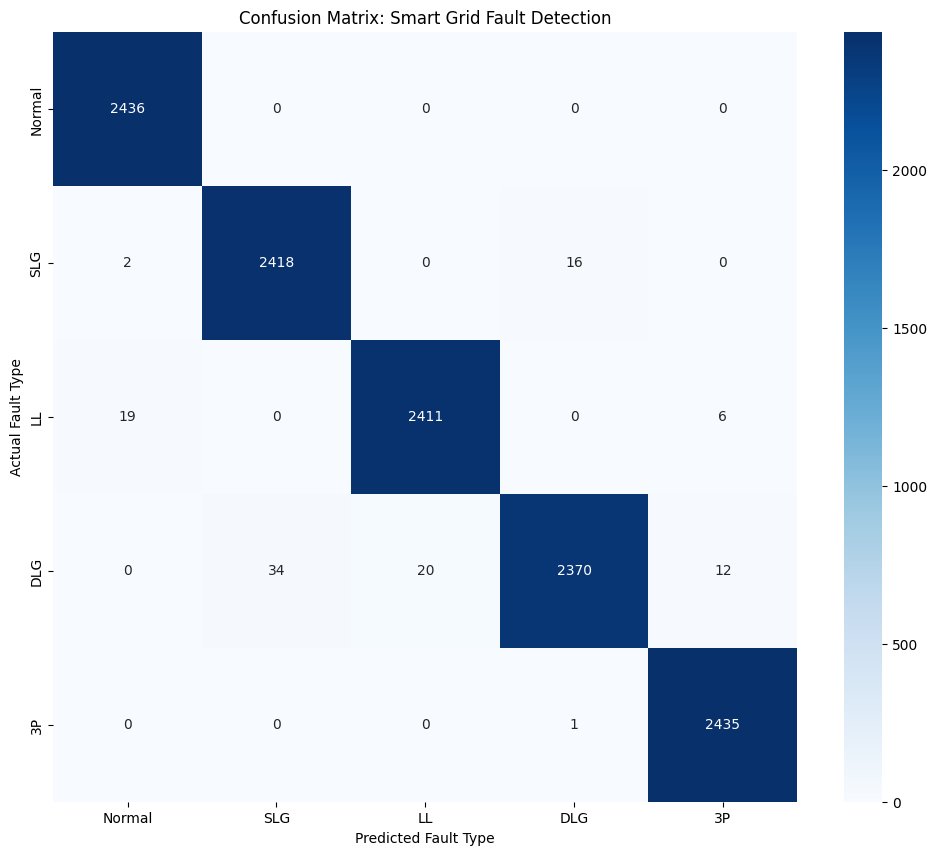

Evaluation complete. Confusion matrix saved to /content/drive/MyDrive/evaluation_confusion_matrix.png


In [18]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

def evaluate():
    global X_PATH, Y_PATH
    MODEL_PATH = '/content/drive/MyDrive/best_fault_model.pth'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    print('Loading data from Google Drive for evaluation...')
    x_raw = pd.read_csv(X_PATH, header=None).values
    y_raw = pd.read_csv(Y_PATH, header=None).iloc[:, 0].values


    dataset = FaultDataset(x_raw, y_raw)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    num_classes = len(np.unique(y_raw))

    model = CNNLSTM(input_dim=12, hidden_dim=64, num_layers=2, num_classes=num_classes).to(device)

    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        print(f'Successfully loaded model from {MODEL_PATH}')
    else:
        print(f'Error: Could not find model at {MODEL_PATH}')
        return

    model.eval()

    all_preds = []
    all_labels = []

    print('Running inference on all samples...')
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    class_names = ['Normal', 'SLG', 'LL', 'DLG', '3P']

    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Fault Type')
    plt.ylabel('Actual Fault Type')
    plt.title('Confusion Matrix: Smart Grid Fault Detection')

    save_img_path = '/content/drive/MyDrive/evaluation_confusion_matrix.png'
    plt.savefig(save_img_path, dpi=300)
    plt.show()

    print(f'Evaluation complete. Confusion matrix saved to {save_img_path}')

evaluate()